<a href="https://colab.research.google.com/github/Us9r/apple-image-classification/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Input Nama]
- **Email:** [Input Email]
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Basic Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Sklearn for data splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# For file operations
import shutil
import zipfile
from pathlib import Path
import glob

# For visualization
# import warnings
# warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

TensorFlow version: 2.18.0
Keras version: 3.8.0


## Data Preparation

### Data Loading

In [3]:
!pip install kaggle

In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten -p ./dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
License(s): CC0-1.0
100% 4.76G/4.77G [02:27<00:00, 15.0MB/s]
100% 4.77G/4.77G [02:27<00:00, 34.6MB/s]


In [13]:
!ls 'dataset/Fruit And Vegetable Diseases Dataset'

Apple__Healthy	     Grape__Healthy   Pomegranate__Healthy
Apple__Rotten	     Grape__Rotten    Pomegranate__Rotten
Banana__Healthy      Guava__Healthy   Potato__Healthy
Banana__Rotten	     Guava__Rotten    Potato__Rotten
Bellpepper__Healthy  Jujube__Healthy  Strawberry__Healthy
Bellpepper__Rotten   Jujube__Rotten   Strawberry__Rotten
Carrot__Healthy      Mango__Healthy   Tomato__Healthy
Carrot__Rotten	     Mango__Rotten    Tomato__Rotten
Cucumber__Healthy    Orange__Healthy
Cucumber__Rotten     Orange__Rotten


In [14]:
DATASET_PATH = 'dataset/Fruit And Vegetable Diseases Dataset'
APPLE_HEALTHY_PATH = os.path.join(DATASET_PATH, 'Apple__Healthy')
APPLE_ROTTEN_PATH = os.path.join(DATASET_PATH, 'Apple__Rotten')

In [16]:
healthy_count = len(os.listdir(APPLE_HEALTHY_PATH))
rotten_count = len(os.listdir(APPLE_ROTTEN_PATH))
total_images = healthy_count + rotten_count

print(f"Healthy apples: {healthy_count} images")
print(f"Rotten apples: {rotten_count} images")
print(f"Total images: {total_images} images")
print(f"Class distribution: {healthy_count/total_images*100:.1f}% healthy, {rotten_count/total_images*100:.1f}% rotten")

Healthy apples: 2438 images
Rotten apples: 2930 images
Total images: 5368 images
Class distribution: 45.4% healthy, 54.6% rotten


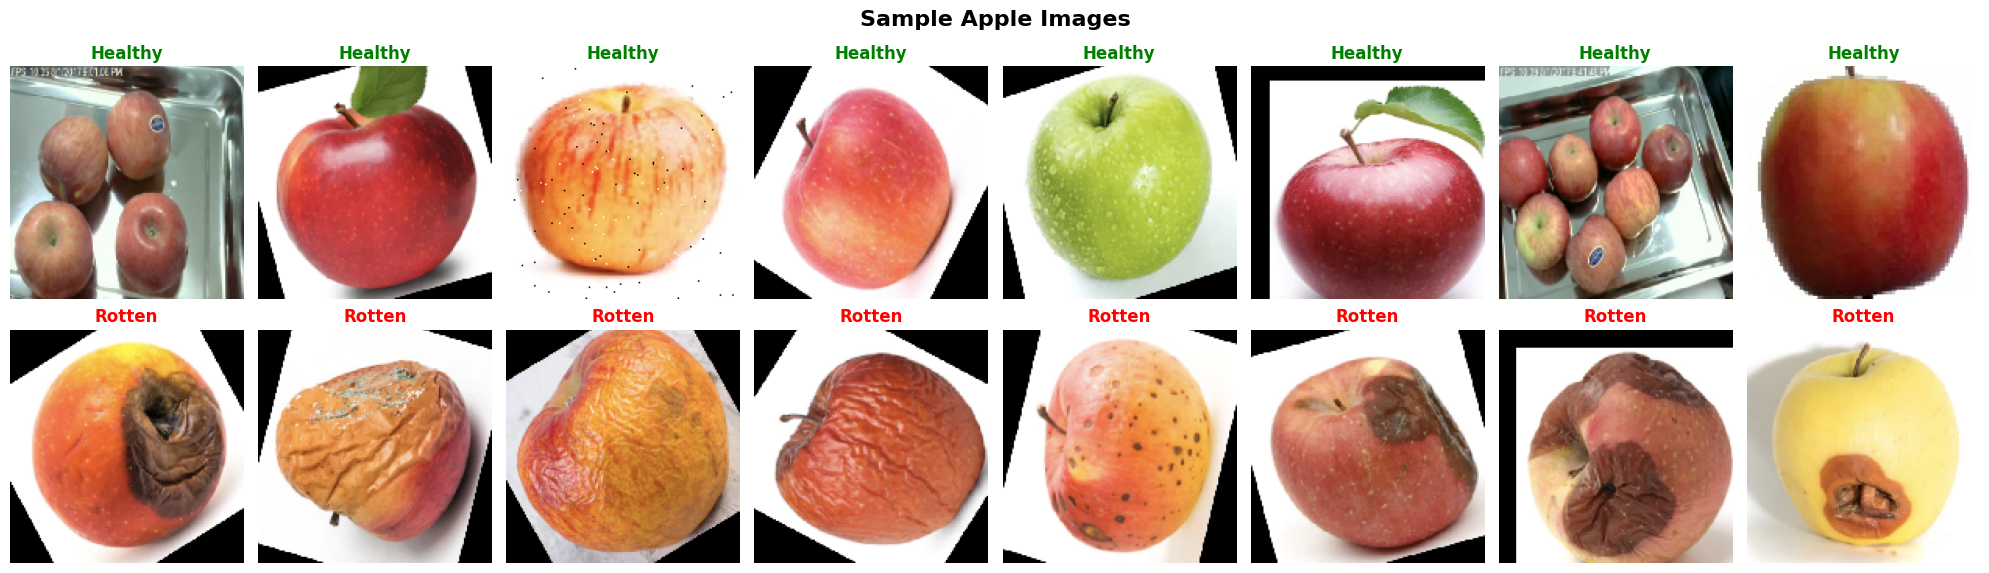

In [17]:
def display_sample_images(healthy_path, rotten_path, num_samples=8):
    """Display sample images from both categories"""

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
    fig.suptitle('Sample Apple Images', fontsize=16, fontweight='bold')

    # Get sample files
    healthy_files = os.listdir(healthy_path)[:num_samples]
    rotten_files = os.listdir(rotten_path)[:num_samples]

    # Display healthy images
    for i, filename in enumerate(healthy_files):
        img_path = os.path.join(healthy_path, filename)
        img = load_img(img_path, target_size=(150, 150))
        axes[0, i].imshow(img)
        axes[0, i].set_title('Healthy', color='green', fontweight='bold')
        axes[0, i].axis('off')

    # Display rotten images
    for i, filename in enumerate(rotten_files):
        img_path = os.path.join(rotten_path, filename)
        img = load_img(img_path, target_size=(150, 150))
        axes[1, i].imshow(img)
        axes[1, i].set_title('Rotten', color='red', fontweight='bold')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(APPLE_HEALTHY_PATH, APPLE_ROTTEN_PATH)

In [19]:
def get_image_stats(image_paths, sample_size=200):
    """Get basic statistics about image dimensions"""

    widths, heights = [], []

    # Sample random images for analysis
    sample_paths = np.random.choice(image_paths, min(sample_size, len(image_paths)), replace=False)

    for img_path in sample_paths:
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except:
            continue

    return widths, heights

# Get all image paths
healthy_paths = [os.path.join(APPLE_HEALTHY_PATH, f) for f in os.listdir(APPLE_HEALTHY_PATH)]
rotten_paths = [os.path.join(APPLE_ROTTEN_PATH, f) for f in os.listdir(APPLE_ROTTEN_PATH)]
all_paths = healthy_paths + rotten_paths

# Analyze image dimensions
widths, heights = get_image_stats(all_paths)

print(f"\nImage dimension statistics (sample of {len(widths)} images):")
print(f"Width  - Min: {min(widths):4d}, Max: {max(widths):4d}, Mean: {np.mean(widths):6.1f}")
print(f"Height - Min: {min(heights):4d}, Max: {max(heights):4d}, Mean: {np.mean(heights):6.1f}")
print(f"Unique dimensions: {len(set(zip(widths, heights)))}")


Image dimension statistics (sample of 200 images):
Width  - Min:  100, Max: 4160, Mean:  591.1
Height - Min:  100, Max: 3331, Mean:  548.2
Unique dimensions: 156


### Data Preprocessing

In [20]:
def prepare_data_paths(healthy_path, rotten_path):
    """Prepare image paths and corresponding labels"""

    # Get all image paths
    healthy_images = [os.path.join(healthy_path, f) for f in os.listdir(healthy_path)]
    rotten_images = [os.path.join(rotten_path, f) for f in os.listdir(rotten_path)]

    # Combine paths and create labels
    image_paths = healthy_images + rotten_images
    labels = [0] * len(healthy_images) + [1] * len(rotten_images)  # 0: healthy, 1: rotten

    return image_paths, labels

# Prepare data
image_paths, labels = prepare_data_paths(APPLE_HEALTHY_PATH, APPLE_ROTTEN_PATH)
print(f"Total images prepared: {len(image_paths)}")
print(f"Label distribution: {labels.count(0)} healthy, {labels.count(1)} rotten")

Total images prepared: 5368
Label distribution: 2438 healthy, 2930 rotten


#### Split Dataset

In [21]:
# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels,
    test_size=0.15,
    random_state=42,
    stratify=labels
)

# Second split: separate train and validation from remaining data
# From remaining 85%: 70% train (59.5% of total), 30% val (25.5% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.3,
    random_state=42,
    stratify=y_temp
)

print(f"\nDataset split:")
print(f"Train: {len(X_train)} images ({len(X_train)/len(image_paths)*100:.1f}%)")
print(f"Validation: {len(X_val)} images ({len(X_val)/len(image_paths)*100:.1f}%)")
print(f"Test: {len(X_test)} images ({len(X_test)/len(image_paths)*100:.1f}%)")


Dataset split:
Train: 3193 images (59.5%)
Validation: 1369 images (25.5%)
Test: 806 images (15.0%)


In [22]:
# Image preprocessing parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generator (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

def create_data_frame(paths, labels):
    """Create DataFrame for ImageDataGenerator flow_from_dataframe"""
    return pd.DataFrame({
        'filename': paths,
        'class': [str(label) for label in labels]
    })

# Create DataFrames
train_df = create_data_frame(X_train, y_train)
val_df = create_data_frame(X_val, y_val)
test_df = create_data_frame(X_test, y_test)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nData generators created:")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Classes: {train_generator.class_indices}")

Found 3190 validated image filenames belonging to 2 classes.
Found 1368 validated image filenames belonging to 2 classes.
Found 805 validated image filenames belonging to 2 classes.

Data generators created:
Image size: 224x224
Batch size: 32
Classes: {'0': 0, '1': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


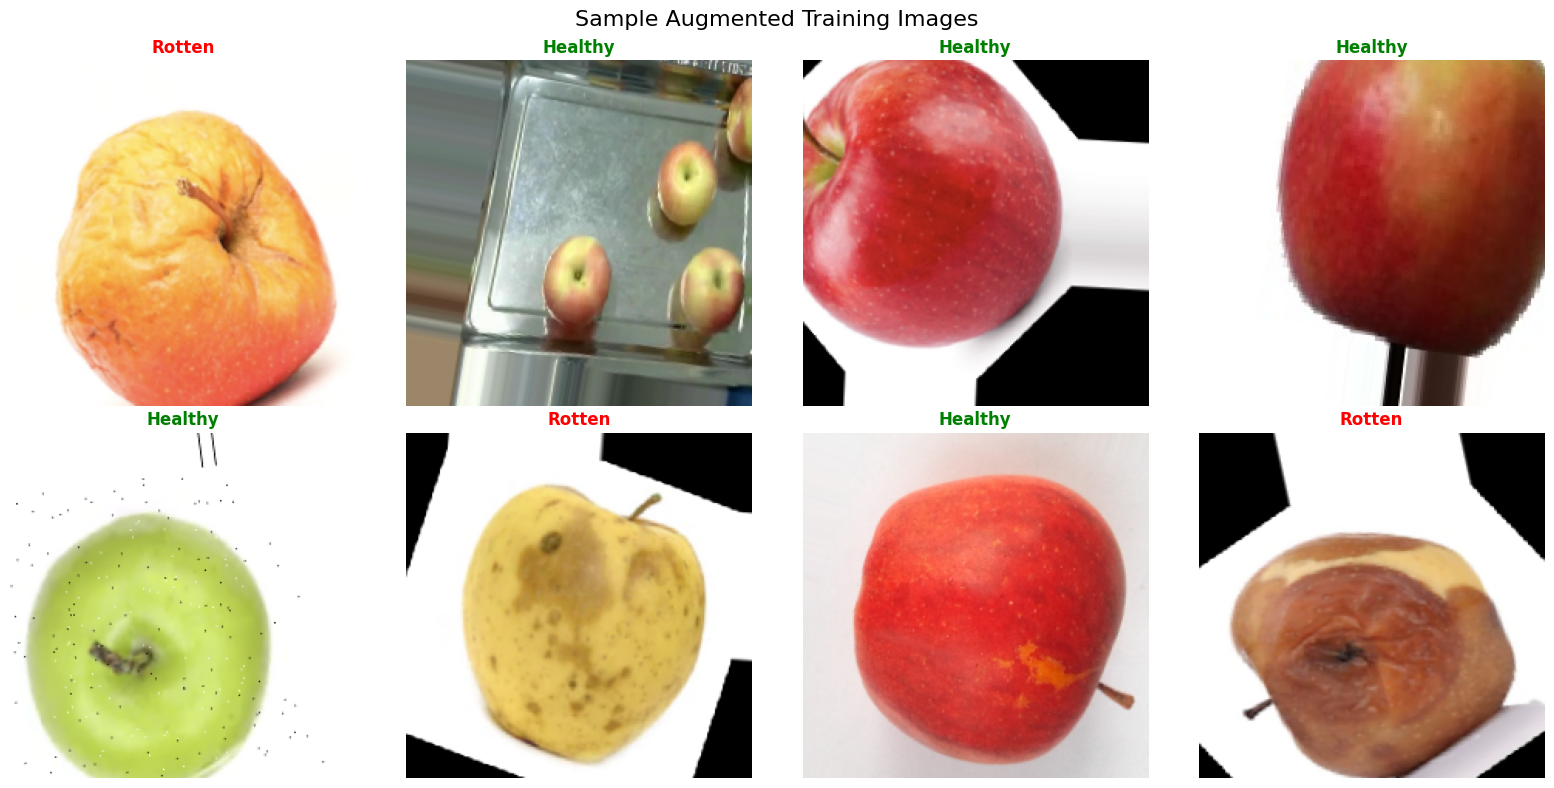

In [23]:
def show_augmented_images(generator, num_images=8):
    """Display augmented images from generator"""

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Augmented Training Images', fontsize=16)

    batch = next(generator)
    images, labels = batch

    for i in range(num_images):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(images[i])

        # Get class name from label
        class_idx = np.argmax(labels[i])
        class_name = 'Healthy' if class_idx == 0 else 'Rotten'
        color = 'green' if class_idx == 0 else 'red'

        axes[row, col].set_title(class_name, color=color, fontweight='bold')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Show augmented samples
show_augmented_images(train_generator)

## Modelling

In [24]:
## Modelling

# Define input shape and number of classes
input_shape=(224, 224, 3)
num_classes=2

# Build CNN model using Sequential API
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Flatten and Dense Layers
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Display model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,399,106 (74.00 MB)

 Trainable params: 19,397,122 (73.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [25]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
# Define callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_apple_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

print("Callbacks configured:")
print("- EarlyStopping: monitor val_loss, patience=10")
print("- ReduceLROnPlateau: reduce LR when val_loss plateaus")
print("- ModelCheckpoint: save best model based on val_accuracy")

Callbacks configured:
- EarlyStopping: monitor val_loss, patience=10
- ReduceLROnPlateau: reduce LR when val_loss plateaus
- ModelCheckpoint: save best model based on val_accuracy


In [ ]:
# Calculate steps per epoch
EPOCHS = 50
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

print(f"Training configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Training configuration:
Epochs: 50
Steps per epoch: 100
Validation steps: 43


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7529 - loss: 0.6731
Epoch 1: val_accuracy improved from -inf to 0.45468, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 806s 8s/step - accuracy: 0.7534 - loss: 0.6716 - val_accuracy: 0.4547 - val_loss: 1.3225 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8580 - loss: 0.3637
Epoch 2: val_accuracy improved from 0.45468 to 0.55409, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 742s 7s/step - accuracy: 0.8581 - loss: 0.3634 - val_accuracy: 0.5541 - val_loss: 0.7346 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8915 - loss: 0.2850
Epoch 3: val_accuracy improved from 0.55409 to 0.68933, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 747s 7s/step - accuracy: 0.8915 - loss: 0.2848 - val_accuracy: 0.6893 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8985 - loss: 0.2402
Epoch 4: val_accuracy improved from 0.68933 to 0.82529, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 742s 7s/step - accuracy: 0.8985 - loss: 0.2404 - val_accuracy: 0.8253 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9080 - loss: 0.2323
Epoch 5: val_accuracy did not improve from 0.82529
100/100 ━━━━━━━━━━━━━━━━━━━━ 705s 7s/step - accuracy: 0.9081 - loss: 0.2322 - val_accuracy: 0.7880 - val_loss: 0.4914 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9061 - loss: 0.2213
Epoch 6: val_accuracy did not improve from 0.82529
100/100 ━━━━━━━━━━━━━━━━━━━━ 777s 7s/step - accuracy: 0.9062 - loss: 0.2213 - val_accuracy: 0.4569 - val_loss: 5.8928 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9080 - loss: 0.2457
Epoch 7: val_accuracy improved from 0.82529 to 0.93640, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 757s 8s/step - accuracy: 0.9081 - loss: 0.2454 - val_accuracy: 0.9364 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9378 - loss: 0.1563
Epoch 8: val_accuracy did not improve from 0.93640
100/100 ━━━━━━━━━━━━━━━━━━━━ 841s 8s/step - accuracy: 0.9377 - loss: 0.1564 - val_accuracy: 0.9335 - val_loss: 0.1639 - learning_rate: 0.0010
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9425 - loss: 0.1554
Epoch 9: val_accuracy improved from 0.93640 to 0.95614, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 759s 8s/step - accuracy: 0.9425 - loss: 0.1555 - val_accuracy: 0.9561 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9512 - loss: 0.1359
Epoch 10: val_accuracy did not improve from 0.95614
100/100 ━━━━━━━━━━━━━━━━━━━━ 754s 7s/step - accuracy: 0.9510 - loss: 0.1362 - val_accuracy: 0.9130 - val_loss: 0.2019 - learning_rate: 0.0010
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9409 - loss: 0.1481
Epoch 11: val_accuracy did not improve from 0.95614
100/100 ━━━━━━━━━━━━━━━━━━━━ 708s 7s/step - accuracy: 0.9408 - loss: 0.1481 - val_accuracy: 0.9247 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9362 - loss: 0.1516
Epoch 12: val_accuracy did not improve from 0.95614
100/100 ━━━━━━━━━━━━━━━━━━━━ 738s 7s/step - accuracy: 0.9363 - loss: 0.1514 - val_accuracy: 0.7895 - val_loss: 0.6688 - learning_rate: 0.0010
Epoch 13/50
100/10

100/100 ━━━━━━━━━━━━━━━━━━━━ 777s 7s/step - accuracy: 0.9578 - loss: 0.1092 - val_accuracy: 0.9766 - val_loss: 0.0684 - learning_rate: 2.0000e-04
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9700 - loss: 0.0755
Epoch 16: val_accuracy improved from 0.97661 to 0.97953, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 797s 7s/step - accuracy: 0.9700 - loss: 0.0756 - val_accuracy: 0.9795 - val_loss: 0.0636 - learning_rate: 2.0000e-04
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9767 - loss: 0.0649
Epoch 17: val_accuracy did not improve from 0.97953
100/100 ━━━━━━━━━━━━━━━━━━━━ 712s 7s/step - accuracy: 0.9767 - loss: 0.0649 - val_accuracy: 0.9759 - val_loss: 0.0697 - learning_rate: 2.0000e-04
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9700 - loss: 0.0800
Epoch 18: val_accuracy improved from 0.97953 to 0.98465, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 734s 7s/step - accuracy: 0.9700 - loss: 0.0801 - val_accuracy: 0.9846 - val_loss: 0.0497 - learning_rate: 2.0000e-04
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9721 - loss: 0.0748
Epoch 19: val_accuracy did not improve from 0.98465
100/100 ━━━━━━━━━━━━━━━━━━━━ 720s 7s/step - accuracy: 0.9721 - loss: 0.0748 - val_accuracy: 0.9773 - val_loss: 0.0653 - learning_rate: 2.0000e-04
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9674 - loss: 0.0769
Epoch 20: val_accuracy did not improve from 0.98465
100/100 ━━━━━━━━━━━━━━━━━━━━ 746s 7s/step - accuracy: 0.9675 - loss: 0.0769 - val_accuracy: 0.9561 - val_loss: 0.1100 - learning_rate: 2.0000e-04
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9714 - loss: 0.0728
Epoch 21: val_accuracy improved from 0.98465 to 0.98611, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 805s 8s/step - accuracy: 0.9714 - loss: 0.0728 - val_accuracy: 0.9861 - val_loss: 0.0419 - learning_rate: 2.0000e-04
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9813 - loss: 0.0519
Epoch 22: val_accuracy did not improve from 0.98611
100/100 ━━━━━━━━━━━━━━━━━━━━ 830s 8s/step - accuracy: 0.9813 - loss: 0.0520 - val_accuracy: 0.9832 - val_loss: 0.0543 - learning_rate: 2.0000e-04
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9778 - loss: 0.0568
Epoch 23: val_accuracy did not improve from 0.98611
100/100 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - accuracy: 0.9778 - loss: 0.0568 - val_accuracy: 0.9861 - val_loss: 0.0463 - learning_rate: 2.0000e-04
Epoch 24/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9838 - loss: 0.0479
Epoch 24: val_accuracy did not improve from 0.98611
100/100 ━━━━━━━━━━━━━━━━━━━━ 731s 7s/step - accuracy: 0.9838 - loss: 0.0480 - val_accuracy: 0.9803 - val_loss: 0.0708 - learning_rate: 2.0000e-04
Ep

100/100 ━━━━━━━━━━━━━━━━━━━━ 749s 7s/step - accuracy: 0.9750 - loss: 0.0673 - val_accuracy: 0.9876 - val_loss: 0.0368 - learning_rate: 2.0000e-04
Epoch 26/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9794 - loss: 0.0510
Epoch 26: val_accuracy did not improve from 0.98757
100/100 ━━━━━━━━━━━━━━━━━━━━ 729s 7s/step - accuracy: 0.9793 - loss: 0.0510 - val_accuracy: 0.9474 - val_loss: 0.1363 - learning_rate: 2.0000e-04
Epoch 27/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9765 - loss: 0.0612
Epoch 27: val_accuracy did not improve from 0.98757
100/100 ━━━━━━━━━━━━━━━━━━━━ 743s 7s/step - accuracy: 0.9765 - loss: 0.0612 - val_accuracy: 0.9876 - val_loss: 0.0452 - learning_rate: 2.0000e-04
Epoch 28/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9746 - loss: 0.0676
Epoch 28: val_accuracy did not improve from 0.98757
100/100 ━━━━━━━━━━━━━━━━━━━━ 741s 7s/step - accuracy: 0.9747 - loss: 0.0676 - val_accuracy: 0.9481 - val_loss: 0.1301 - learning_rate: 2.0000e-04
Ep

100/100 ━━━━━━━━━━━━━━━━━━━━ 747s 7s/step - accuracy: 0.9900 - loss: 0.0393 - val_accuracy: 0.9883 - val_loss: 0.0304 - learning_rate: 4.0000e-05
Epoch 34/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9864 - loss: 0.0380
Epoch 34: val_accuracy did not improve from 0.98830
100/100 ━━━━━━━━━━━━━━━━━━━━ 788s 7s/step - accuracy: 0.9864 - loss: 0.0380 - val_accuracy: 0.9883 - val_loss: 0.0374 - learning_rate: 4.0000e-05
Epoch 35/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9839 - loss: 0.0353
Epoch 35: val_accuracy improved from 0.98830 to 0.98904, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 728s 7s/step - accuracy: 0.9839 - loss: 0.0353 - val_accuracy: 0.9890 - val_loss: 0.0327 - learning_rate: 4.0000e-05
Epoch 36/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9901 - loss: 0.0334
Epoch 36: val_accuracy improved from 0.98904 to 0.99123, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 705s 7s/step - accuracy: 0.9901 - loss: 0.0334 - val_accuracy: 0.9912 - val_loss: 0.0303 - learning_rate: 4.0000e-05
Epoch 37/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9849 - loss: 0.0378
Epoch 37: val_accuracy did not improve from 0.99123
100/100 ━━━━━━━━━━━━━━━━━━━━ 778s 7s/step - accuracy: 0.9849 - loss: 0.0378 - val_accuracy: 0.9876 - val_loss: 0.0322 - learning_rate: 4.0000e-05
Epoch 38/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9853 - loss: 0.0377
Epoch 38: val_accuracy did not improve from 0.99123
100/100 ━━━━━━━━━━━━━━━━━━━━ 717s 7s/step - accuracy: 0.9853 - loss: 0.0377 - val_accuracy: 0.9883 - val_loss: 0.0302 - learning_rate: 4.0000e-05
Epoch 39/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9862 - loss: 0.0375
Epoch 39: val_accuracy improved from 0.99123 to 0.99269, saving model to best_apple_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 687s 7s/step - accuracy: 0.9863 - loss: 0.0375 - val_accuracy: 0.9927 - val_loss: 0.0293 - learning_rate: 4.0000e-05
Epoch 40/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9816 - loss: 0.0426
Epoch 40: val_accuracy did not improve from 0.99269
100/100 ━━━━━━━━━━━━━━━━━━━━ 751s 7s/step - accuracy: 0.9816 - loss: 0.0426 - val_accuracy: 0.9927 - val_loss: 0.0277 - learning_rate: 4.0000e-05
Epoch 41/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9838 - loss: 0.0451
Epoch 41: val_accuracy did not improve from 0.99269
100/100 ━━━━━━━━━━━━━━━━━━━━ 737s 7s/step - accuracy: 0.9839 - loss: 0.0451 - val_accuracy: 0.9927 - val_loss: 0.0257 - learning_rate: 4.0000e-05
Epoch 42/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9914 - loss: 0.0278
Epoch 42: val_accuracy did not improve from 0.99269
100/100 ━━━━━━━━━━━━━━━━━━━━ 747s 7s/step - accuracy: 0.9914 - loss: 0.0278 - val_accuracy: 0.9920 - val_loss: 0.0265 - learning_rate: 4.0000e-05
Ep

100/100 ━━━━━━━━━━━━━━━━━━━━ 743s 7s/step - accuracy: 0.9884 - loss: 0.0386 - val_accuracy: 0.9934 - val_loss: 0.0246 - learning_rate: 4.0000e-05
Epoch 44/50
 31/100 ━━━━━━━━━━━━━━━━━━━━ 7:27 6s/step - accuracy: 0.9931 - loss: 0.0219

## Evaluasi dan Visualisasi

## Konversi Model

In [2]:
# prompt: simpan dan download model

# Save the trained model
model_save_path = 'apple_disease_model.h5'
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

# Download the saved model
files.download(model_save_path)
print(f"Model '{model_save_path}' downloaded.")

NameError: name 'model' is not defined

## Inference (Optional)